In [1]:
import numpy as np
import pandas as pd

import random
random.seed(28)
np.random.seed(28)

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import time
from collections import Counter
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

np.random.seed(2206)

# Read the data

In [2]:
train = pd.read_csv("../data/training_v2.csv")
samplesubmission = pd.read_csv("../data/samplesubmission.csv")
test = pd.read_csv("../data/unlabeled.csv")
dictionary = pd.read_csv("../data/WiDS Datathon 2020 Dictionary.csv")
solution_template = pd.read_csv("../data/solution_template.csv")

print('train ' , train.shape)
print('test ' , test.shape)
print('samplesubmission ' , samplesubmission.shape)
print('solution_template ' , solution_template.shape)
print('dictionary ' , dictionary.shape)

train  (91713, 186)
test  (39308, 186)
samplesubmission  (3, 2)
solution_template  (39308, 2)
dictionary  (188, 6)


In [3]:
dico = pd.DataFrame(dictionary.T.head(6))
dico.columns=list(dico.loc[dico.index == 'Variable Name'].unstack())
dico = dico.loc[dico.index != 'Variable Name']
dico.columns
train_stat = pd.DataFrame(train.describe())
train_stat2 = pd.concat([dico,train_stat],axis=0)
train_stat2.head(20)

,age,aids,albumin_apache,apache_2_bodysystem,apache_2_diagnosis,apache_3j_bodysystem,apache_3j_diagnosis,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,apache_post_operative,arf_apache,bilirubin_apache,bmi,bun_apache,cirrhosis,creatinine_apache,d1_albumin_max,d1_albumin_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_heartrate_max,d1_heartrate_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_resprate_max,d1_resprate_min,d1_sodium_max,d1_sodium_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,d1_wbc_max,d1_wbc_min,diabetes_mellitus,elective_surgery,encounter_id,ethnicity,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,gender,glucose_apache,h1_albumin_max,h1_albumin_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_heartrate_max,h1_heartrate_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_resprate_max,h1_resprate_min,h1_sodium_max,h1_sodium_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,h1_wbc_max,h1_wbc_min,heart_rate_apache,height,hematocrit_apache,hepatic_failure,hospital_admit_source,hospital_death,hospital_id,icu_admit_source,icu_admit_type,icu_id,icu_stay_type,icu_type,immunosuppression,intubated_apache,leukemia,lymphoma,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,patient_id,ph_apache,pre_icu_los_days,pred,readmission_status,resprate_apache,sodium_apache,solid_tumor_with_metastasis,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,weight
Category,demographic,APACHE comorbidity,APACHE covariate,APACHE grouping,APACHE covariate,APACHE grouping,APACHE covariate,APACHE prediction,APACHE prediction,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,APACHE comorbidity,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,labs,labs,vitals,vitals,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs blood gas,labs blood gas,labs,labs,labs,labs,vitals,vitals,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,APACHE comorbidity,demographic,identifier,demographic,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas

# OverView of the dataset

In [4]:
train_stat2.T.head(200)

,Category,Unit of Measure,Data Type,Description,Example,count,mean,std,min,25%,50%,75%,max
age,demographic,Years,numeric,The age of the patient on unit admission,None,"87,485.00",62.31,16.78,16.00,52.00,65.00,75.00,89.00
aids,APACHE comorbidity,None,binary,Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone),1,"90,998.00",0.00,0.03,0.00,0.00,0.00,0.00,1.00
albumin_apache,APACHE covariate,g/L,numeric,The albumin concentration measured during the first 24 hours which results in the highest APACHE III score,30,"37,334.00",2.90,0.68,1.20,2.40,2.90,3.40,4.60
apache_2_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE II,Respiratory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_2_diagnosis,APACHE covariate,None,string,The APACHE II diagnosis for the ICU admission,308,"90,051.00",185.40,86.05,101.00,113.00,122.00,301.00,308.00
apache_3j_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE III,Cardiovascular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_3j_diagnosis,APACHE covariate,None,string,The APACHE III-J sub-diagnosis code which best describes the reason for the ICU admission,1405,"90,612.00",558.22,463.27,0.01,203.01,409.02,703.03,"2,201.05"
apache_4a_hospital_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.",0.31,"83,766.00",0.09,0.25,-1.00,0.02,0.05,0.13,0.99
apache_4a_icu_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis",0.24,"83,766.00",0.04,0.22,-1.00,0.01,0.02,0.06,0.97
apache_post_operative,APACHE covariate,None,binary,"The APACHE operative status; 1 for post-operative, 0 for non-operative",1,"91,713.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


## EDA

In [5]:
# Missing Values
train.isna().sum()

encounter_id                     0    
patient_id                       0    
hospital_id                      0    
hospital_death                   0    
age                              4228 
bmi                              3429 
elective_surgery                 0    
ethnicity                        1395 
gender                           25   
height                           1334 
hospital_admit_source            21409
icu_admit_source                 112  
icu_id                           0    
icu_stay_type                    0    
icu_type                         0    
pre_icu_los_days                 0    
readmission_status               0    
weight                           2720 
albumin_apache                   54379
apache_2_diagnosis               1662 
apache_3j_diagnosis              1101 
apache_post_operative            0    
arf_apache                       715  
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache        

## Functions

In [6]:
# function to evaluate the score of our model
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc    

In [7]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [8]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                  'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'metric': 'auc',
                  'subsample': 0.75,
                  'subsample_freq': 1,
                  'learning_rate': 0.1,
                  'feature_fraction': 0.9,
                  'max_depth': 15,
                  'lambda_l1': 1,  
                  'lambda_l2': 1,
                  'early_stopping_rounds': 100,
                  #'is_unbalance' : True ,
                  'scale_pos_weight' : 3,
                  'device': 'gpu',
                  'gpu_platform_id': 0,
                  'gpu_device_id': 0,
                  'num_leaves': 31
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
            params['subsample']=ps['subsample']
            params['num_leaves']=int(ps['num_leaves'])
            params['min_split_gain']=ps['min_split_gain']
#             params['min_child_weight']=ps['min_child_weight']
        
        return params  

In [9]:
def plot_importances(importances_, plot_name):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('{}.png'.format(plot_name))
    plt.show()

## Pre Processing

In [10]:
# Replace values

print('Replacing: {}'.format('hospital_admit_source'))

replace_hospital_admit_source =  {'Other ICU': 'ICU',
                                  'ICU to SDU':'SDU', 
                                  'Step-Down Unit (SDU)': 'SDU', 
                                  'Other Hospital':'Other',
                                  'Observation': 'Recovery Room',
                                  'Acute Care/Floor': 'Acute Care'}
train['hospital_admit_source'].replace(replace_hospital_admit_source, inplace=True)
test['hospital_admit_source'].replace(replace_hospital_admit_source, inplace=True)

#combined_dataset['icu_type'] = combined_dataset['icu_type'].replace({'CCU-CTICU': 'Grpd_CICU', 'CTICU':'Grpd_CICU', 'Cardiac ICU':'Grpd_CICU'})

print('Replacing: {}'.format('apache_2_bodysystem'))

replace_apache_2_bodysystem =  {'Undefined diagnoses': 'Undefined Diagnoses'}
train['apache_2_bodysystem'].replace(replace_apache_2_bodysystem, inplace=True)
test['apache_2_bodysystem'].replace(replace_apache_2_bodysystem, inplace=True)

Replacing: hospital_admit_source
Replacing: apache_2_bodysystem


In [11]:
#we are going to drop these columns because we dont want our ML model to be bias toward these consideration
#(we also remove the target and the ids.)
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']

# this is a list of features that look like to be categorical
categoricals_features = ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source',
                         'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# this is the list of all input feature we would like our model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', train.shape , test.shape)

numerber of features  181
shape of train / test  (91713, 186) (39308, 186)


categorical feature need to be transform to numeric for mathematical purpose.
different technics of categorical encoding exists here we will rely on our model API to deal with categorical
still we need to encode each categorical value to an id , for this purpose we use LabelEncoder


In [12]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categoricals_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



## Adversarial Validation

The main idea of adversarial validation is to detect shift/drift in the different features between 2 datasets.

We usually train a model on past data to forecast future data so it can happened that these futures datas have a distribution that is no longer in line with the data we used for training, or maybe we train on some hospital datas and apply our model on other hospital ?

You can detect drift by statistical test (like t-test) but here we will do it by training a machine learning model and check if the model can figure out if the data is from the train or test set. If it can, this means that the test data comes from another distribution compare to the train data and then you have to check the distribution of the most important features that are likely to be different between train and test.

In [13]:
def adversarial_validation(train, test, features):
    tr_data   = train.copy()
    tst_data = test.copy()
    tr_data['target']  = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data, tst_data], axis = 0)
    av_data.reset_index(drop = True)        
    params = {
            'learning_rate': 0.1, 
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric': 'auc',
        }    
    # define a KFold strategy
    kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, av_data[target])) :
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[features].iloc[tr_ind], av_data[features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set   = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 20, valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = features
        fold_importance['gain'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(metrics.roc_auc_score(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :', metrics.roc_auc_score(av_data[target], oof_pred))
    return important_features

In [14]:
# run the adversatial model with all the feature we used :
    
adversarial_features = adversarial_validation(train, test, features)

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.999923	valid_1's auc: 0.999668
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.999903	valid_1's auc: 0.999739
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	training's auc: 0.999975	valid_1's auc: 0.999695
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[9]	training's auc: 0.999933	valid_1's auc: 0.999701
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	training's auc: 0.999998	valid_1's auc: 0.999744
Our mean train roc auc score is : 0.9999464223517089
Our oof roc auc score is : 0.9993863701821477


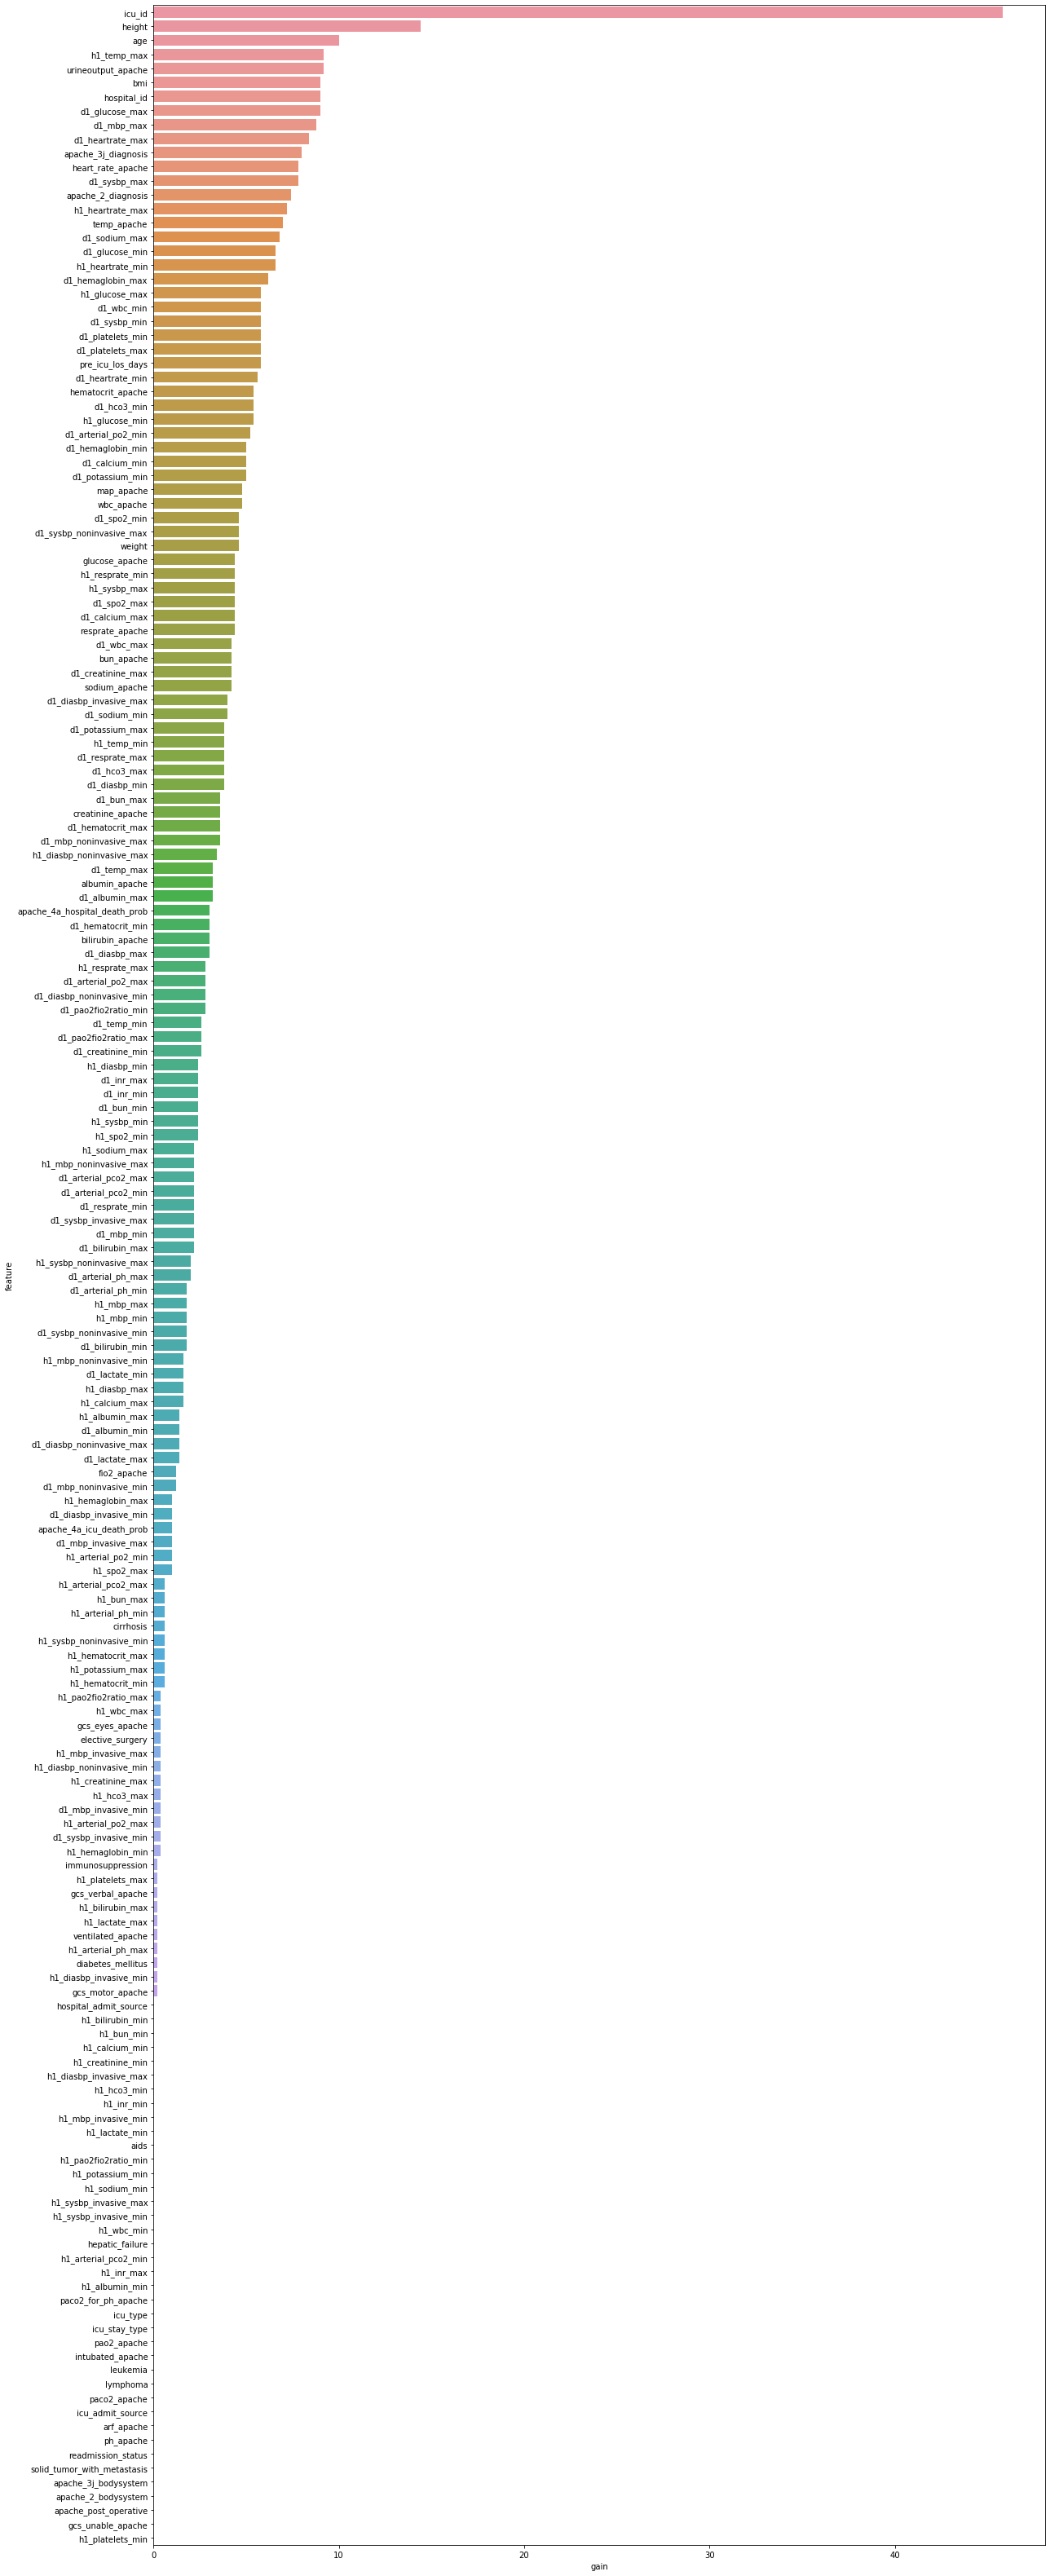

In [15]:
# AUC is almost perfect so we can expect that some feature are perfectly different between train / test

adversarial_features = adversarial_features[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features= adversarial_features.sort_values('gain', ascending=False)

plot_importances(adversarial_features, 'importances-lgb-v6')

icu_id 0 gain : 45.8


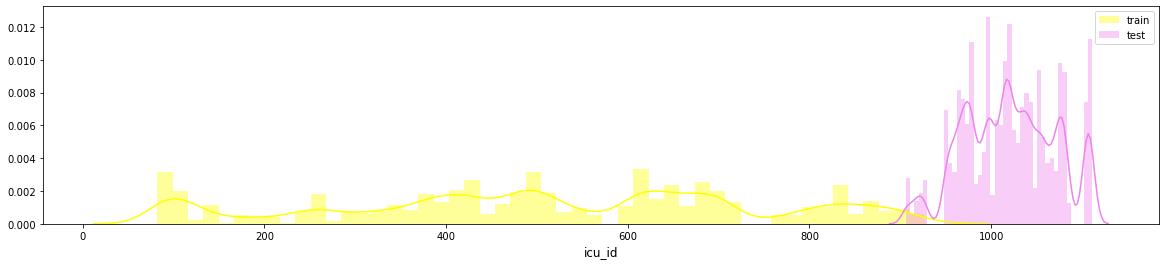

height 1 gain : 14.4


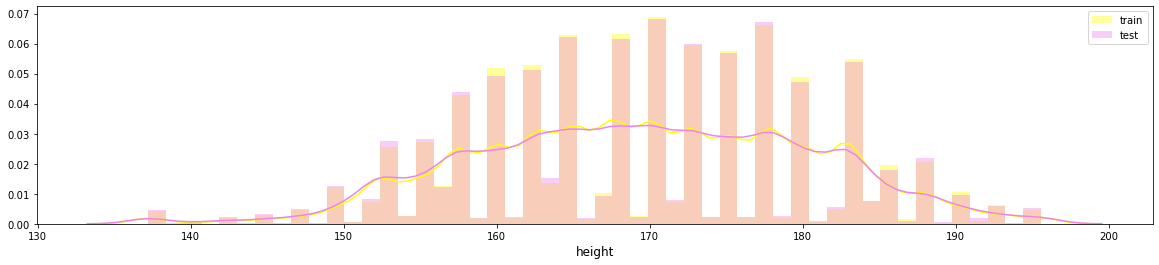

age 2 gain : 10.0


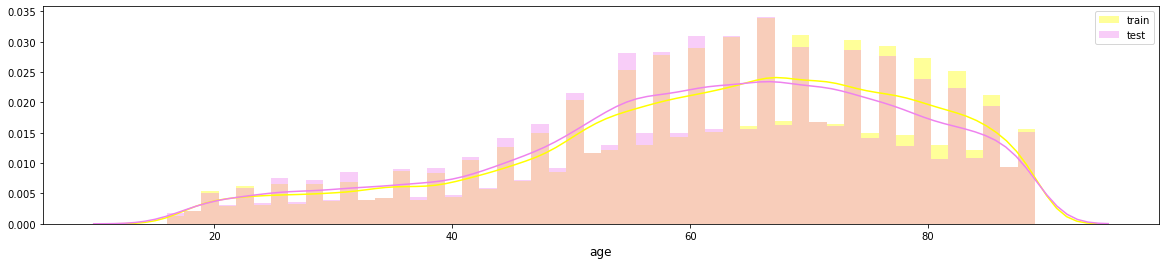

h1_temp_max 3 gain : 9.2


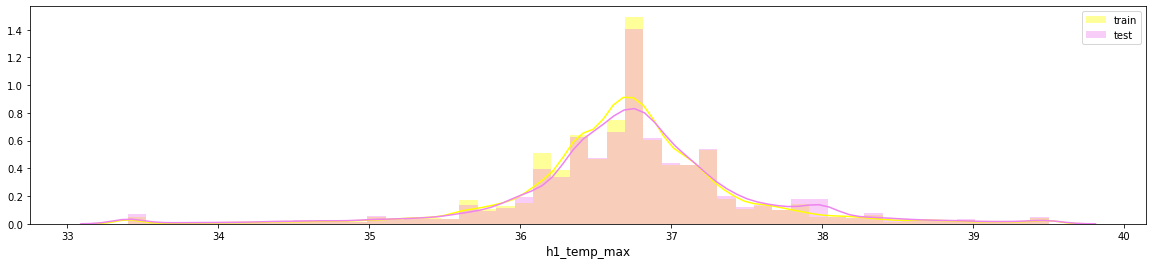

urineoutput_apache 4 gain : 9.2


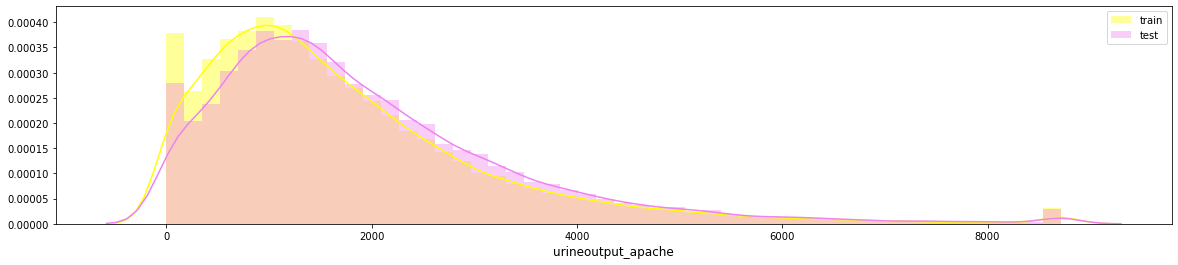

bmi 5 gain : 9.0


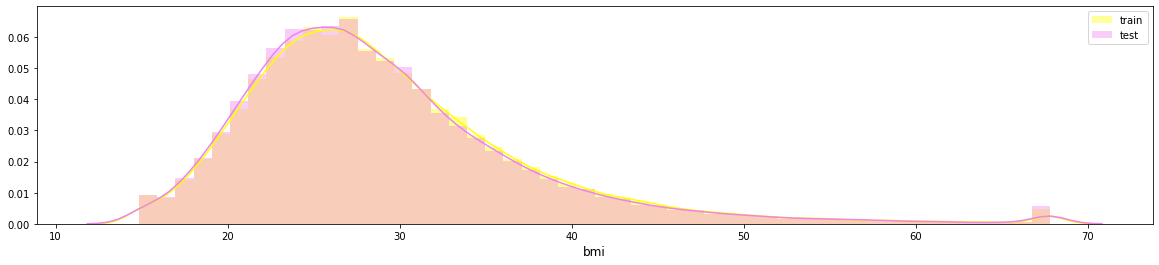

hospital_id 6 gain : 9.0


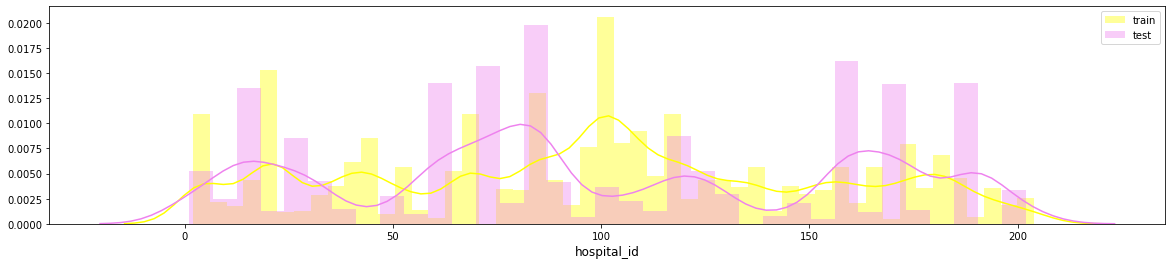

d1_glucose_max 7 gain : 9.0


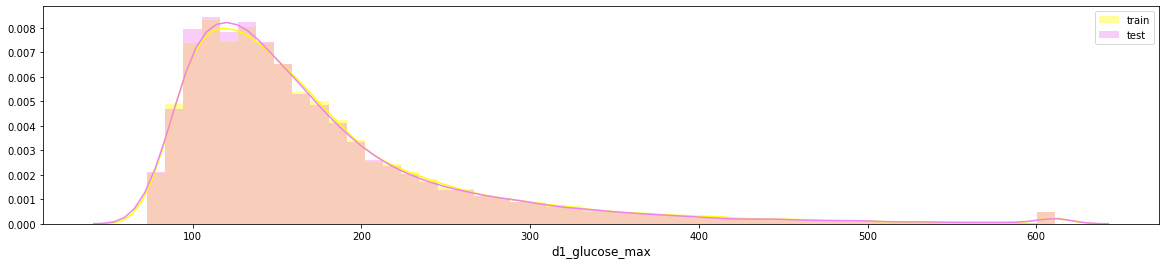

d1_mbp_max 8 gain : 8.8


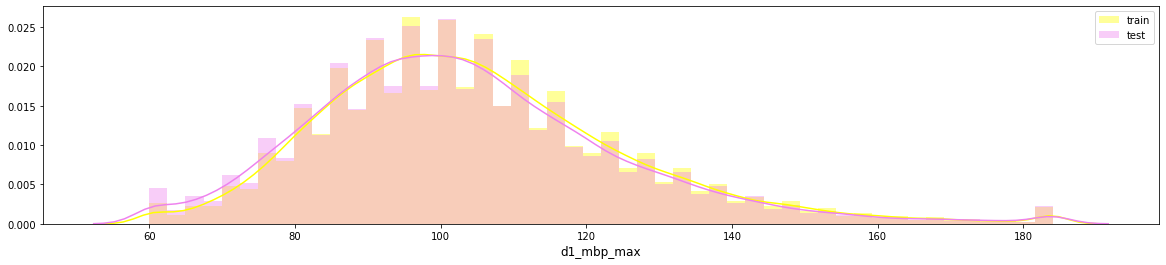

d1_heartrate_max 9 gain : 8.4


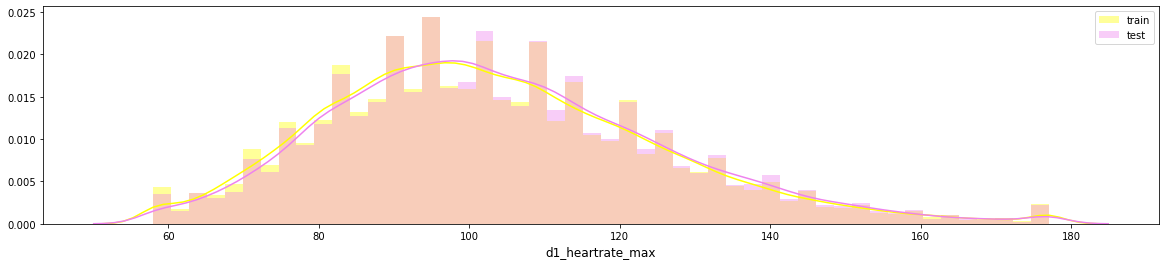

In [16]:
# So icu_id columns seems to be the feature that dominate the feature importance for the adversarial 
# validation model, so it is likely to be totally different between train and test, 
# lets check the distribution of the top features :

def plot_differente_between_train_test(adversarial_features):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.simplefilter(action='ignore', category=UserWarning)
    i=0
    for index, row in adversarial_features.sort_values(by=['gain'],ascending=False).iterrows():  
        column=row['feature']
        if i< 10:
                print(column,i,"gain :",row['gain'])
                df1      = train.copy()
                df2      = test.copy()

                fig = plt.figure(figsize=(20,4))
                sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
                sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
                fig=plt.legend(loc='best')
                plt.xlabel(column, fontsize=12);
                plt.show()
                i=i+1

plot_differente_between_train_test(adversarial_features)

In [17]:
# it is .... Let's remove icu_id and see the results ..
adversarial_features2 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999746	valid_1's auc: 0.999615
[200]	training's auc: 0.999992	valid_1's auc: 0.999667
Early stopping, best iteration is:
[234]	training's auc: 0.999998	valid_1's auc: 0.999677
Fold 2
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999745	valid_1's auc: 0.999567
Early stopping, best iteration is:
[114]	training's auc: 0.999813	valid_1's auc: 0.999578
Fold 3
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999733	valid_1's auc: 0.999673
Early stopping, best iteration is:
[125]	training's auc: 0.999845	valid_1's auc: 0.999689
Fold 4
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999753	valid_1's auc: 0.999655
[200]	training's auc: 0.999993	valid_1's auc: 0.999674
Early stopping, best iteration is:
[183]	training's auc: 0.999985	valid_1's auc: 0.999675
Fold 5
Training until validation score

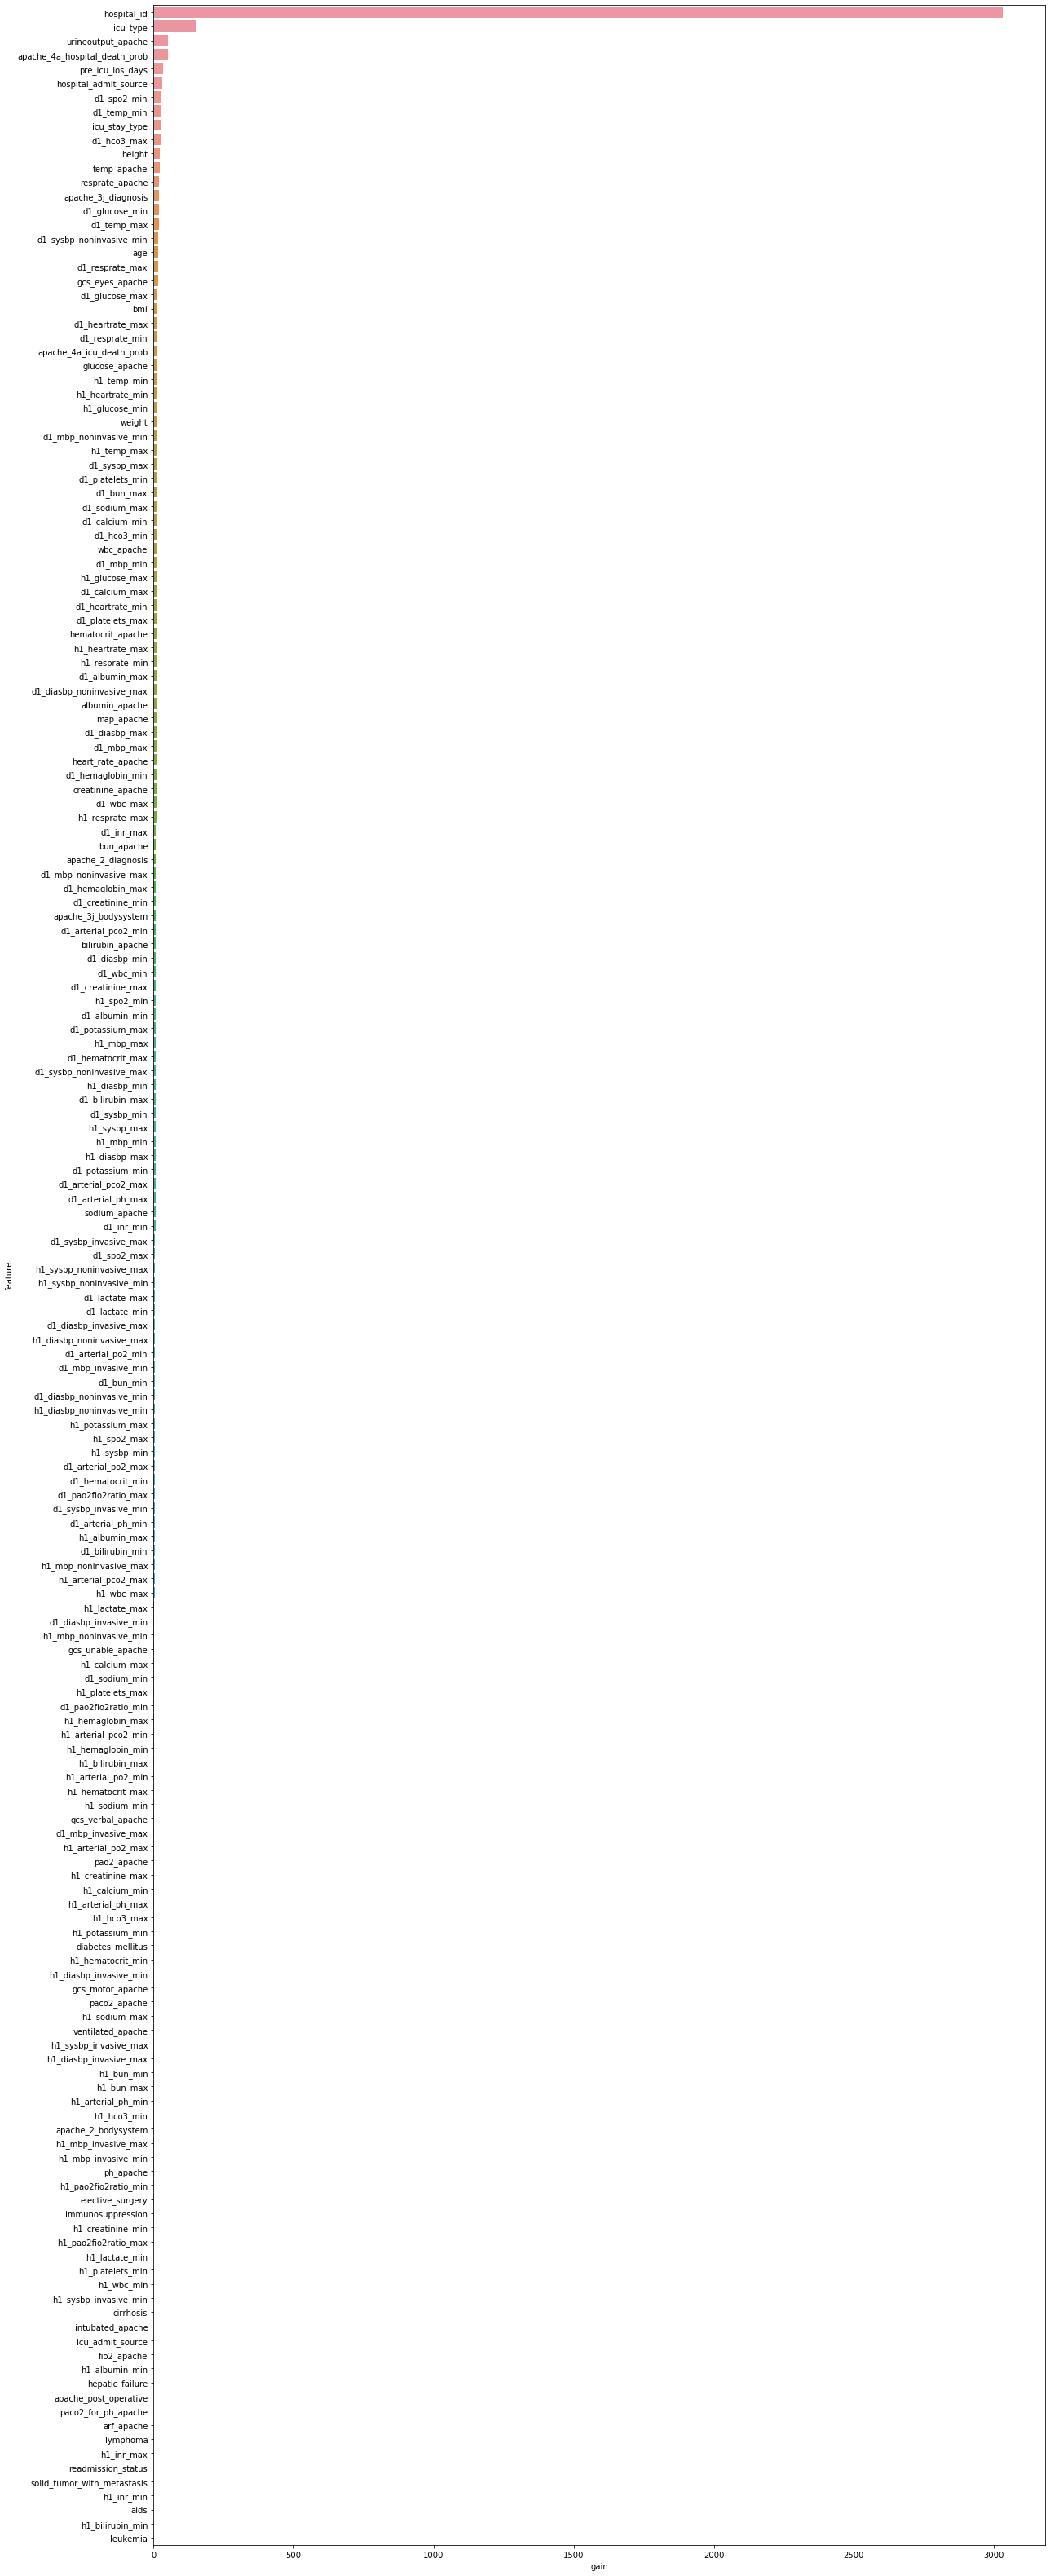

In [18]:
# Let`s check again the difference between train / test

adversarial_features2 = adversarial_features2[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features2= adversarial_features2.sort_values('gain', ascending=False)

plot_importances(adversarial_features2, 'importances-lgb-v6')

hospital_id 0 gain : 3030.2


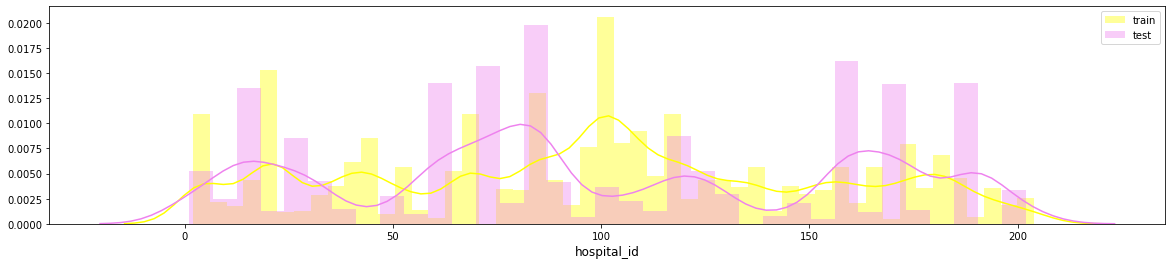

icu_type 1 gain : 150.2


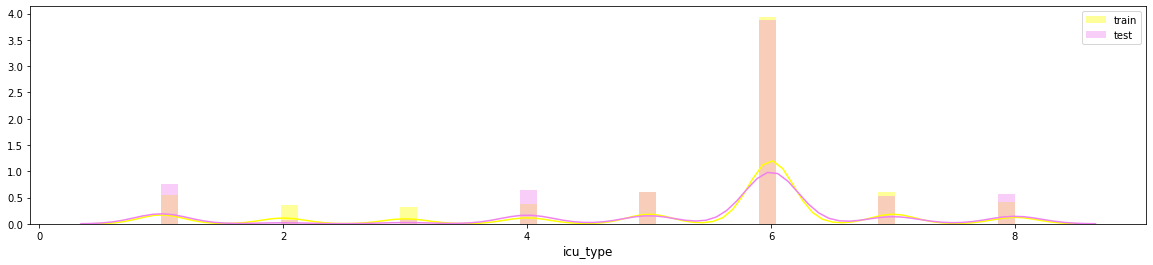

urineoutput_apache 2 gain : 51.4


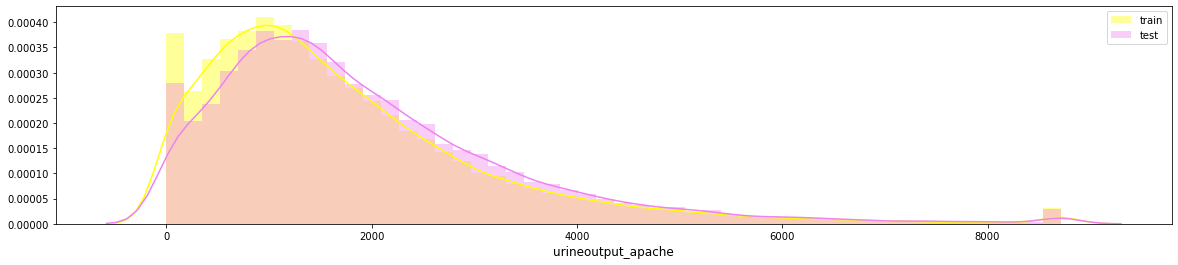

apache_4a_hospital_death_prob 3 gain : 51.4


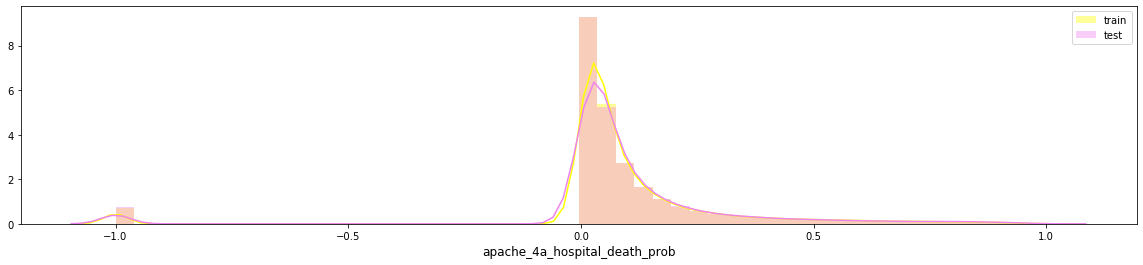

pre_icu_los_days 4 gain : 34.8


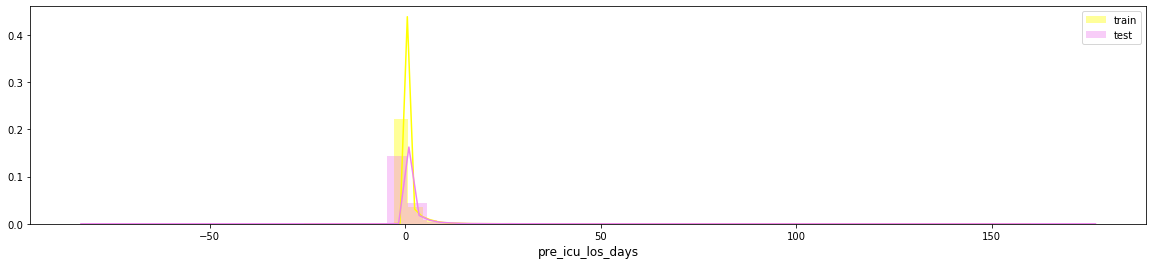

hospital_admit_source 5 gain : 29.8


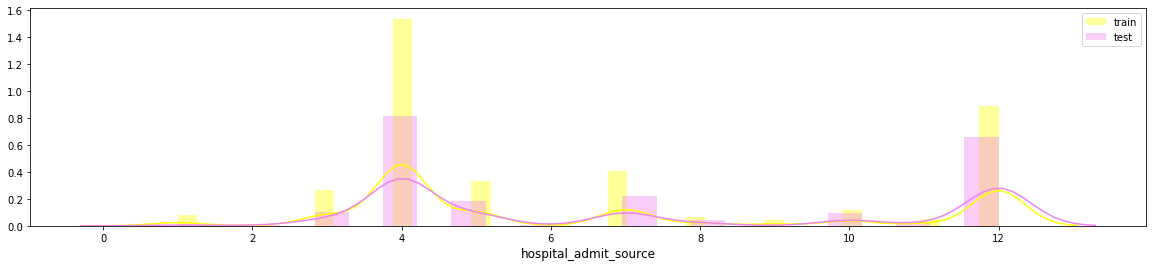

d1_spo2_min 6 gain : 27.6


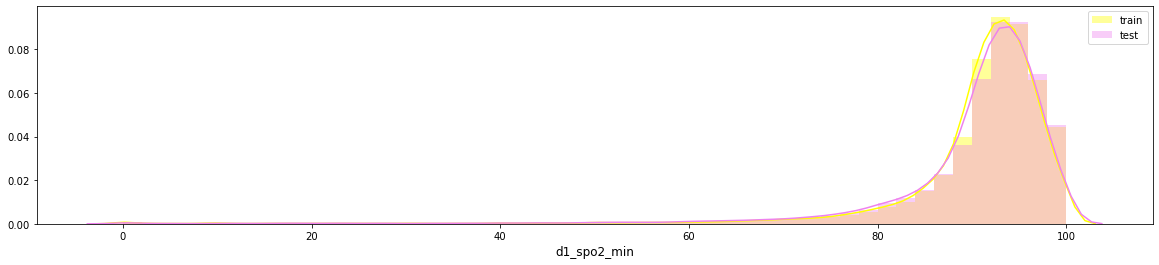

d1_temp_min 7 gain : 27.2


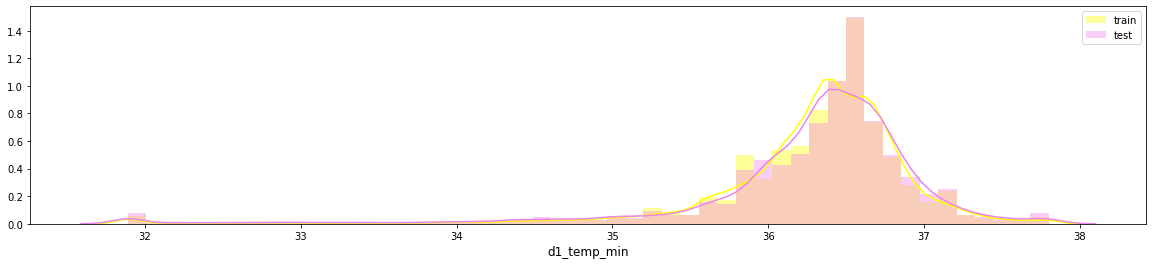

icu_stay_type 8 gain : 26.0


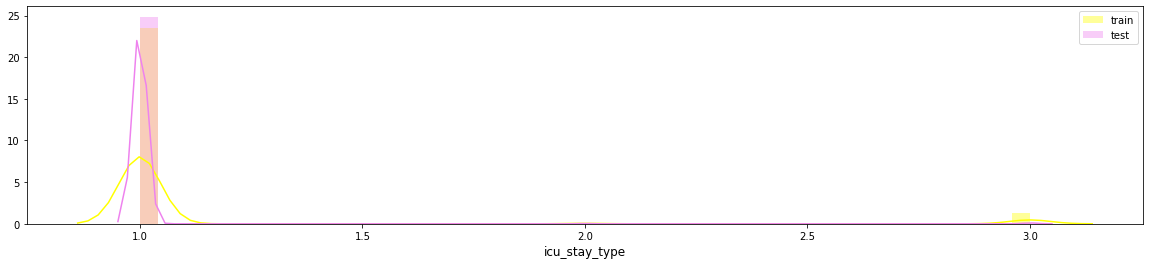

d1_hco3_max 9 gain : 24.8


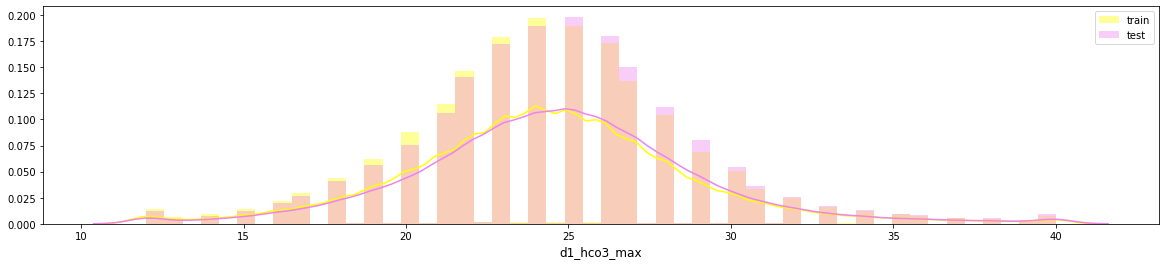

In [19]:
plot_differente_between_train_test(adversarial_features2)

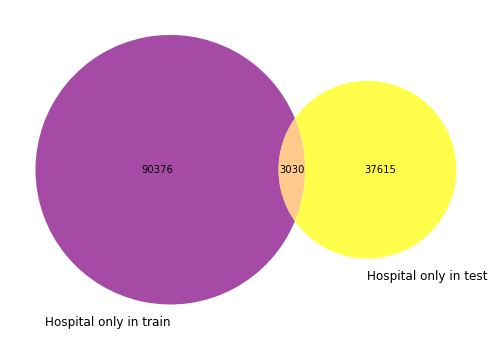

In [20]:
# hospital_id seems to be also from a different distribution. 
# We can check it directly, obviously only few hospital are common to both dataset ..

common_id  = list([id for id in train['hospital_id'].unique() if id in test['hospital_id'].unique() ])
id_only_in_train  = [id for id in train['hospital_id'].unique() if id not in test['hospital_id'].unique() ]
id_only_in_test   = [id for id in test['hospital_id'].unique()  if id not in train['hospital_id'].unique() ]
count_common_train = train.loc[train['hospital_id'].isin(common_id)].shape[0]
count_common_test  = test.loc[test['hospital_id'].isin(common_id)].shape[0]

count_train = train.loc[train['hospital_id'].isin(id_only_in_train)].shape[0]
count_test  = test.loc[test['hospital_id'].isin(id_only_in_test)].shape[0]

 
fig = plt.figure(figsize=(20,6))
venn2(subsets = (count_train,  count_test, count_common_train+count_common_test), set_labels = ('Hospital only in train', 'Hospital only in test'),set_colors=('purple', 'yellow'), alpha = 0.7);
plt.show()

In [21]:
# Let's do an ultimate try without 'icu_id','hospitaadversarial_features3 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id'] ])l_id'
adversarial_features3 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.900891	valid_1's auc: 0.882105
[200]	training's auc: 0.928589	valid_1's auc: 0.894707
[300]	training's auc: 0.946802	valid_1's auc: 0.900464
[400]	training's auc: 0.959356	valid_1's auc: 0.903758
[500]	training's auc: 0.968976	valid_1's auc: 0.905591
[600]	training's auc: 0.975936	valid_1's auc: 0.907556
[700]	training's auc: 0.981804	valid_1's auc: 0.909469
Early stopping, best iteration is:
[698]	training's auc: 0.98174	valid_1's auc: 0.909484
Fold 2
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.900229	valid_1's auc: 0.878325
[200]	training's auc: 0.928365	valid_1's auc: 0.891483
[300]	training's auc: 0.946494	valid_1's auc: 0.896898
[400]	training's auc: 0.959466	valid_1's auc: 0.900784
[500]	training's auc: 0.969129	valid_1's auc: 0.9029
[600]	training's auc: 0.976295	valid_1's auc: 0.904763
[700]	training's auc: 0.982147	valid_1's auc: 0.906733
[800]	t

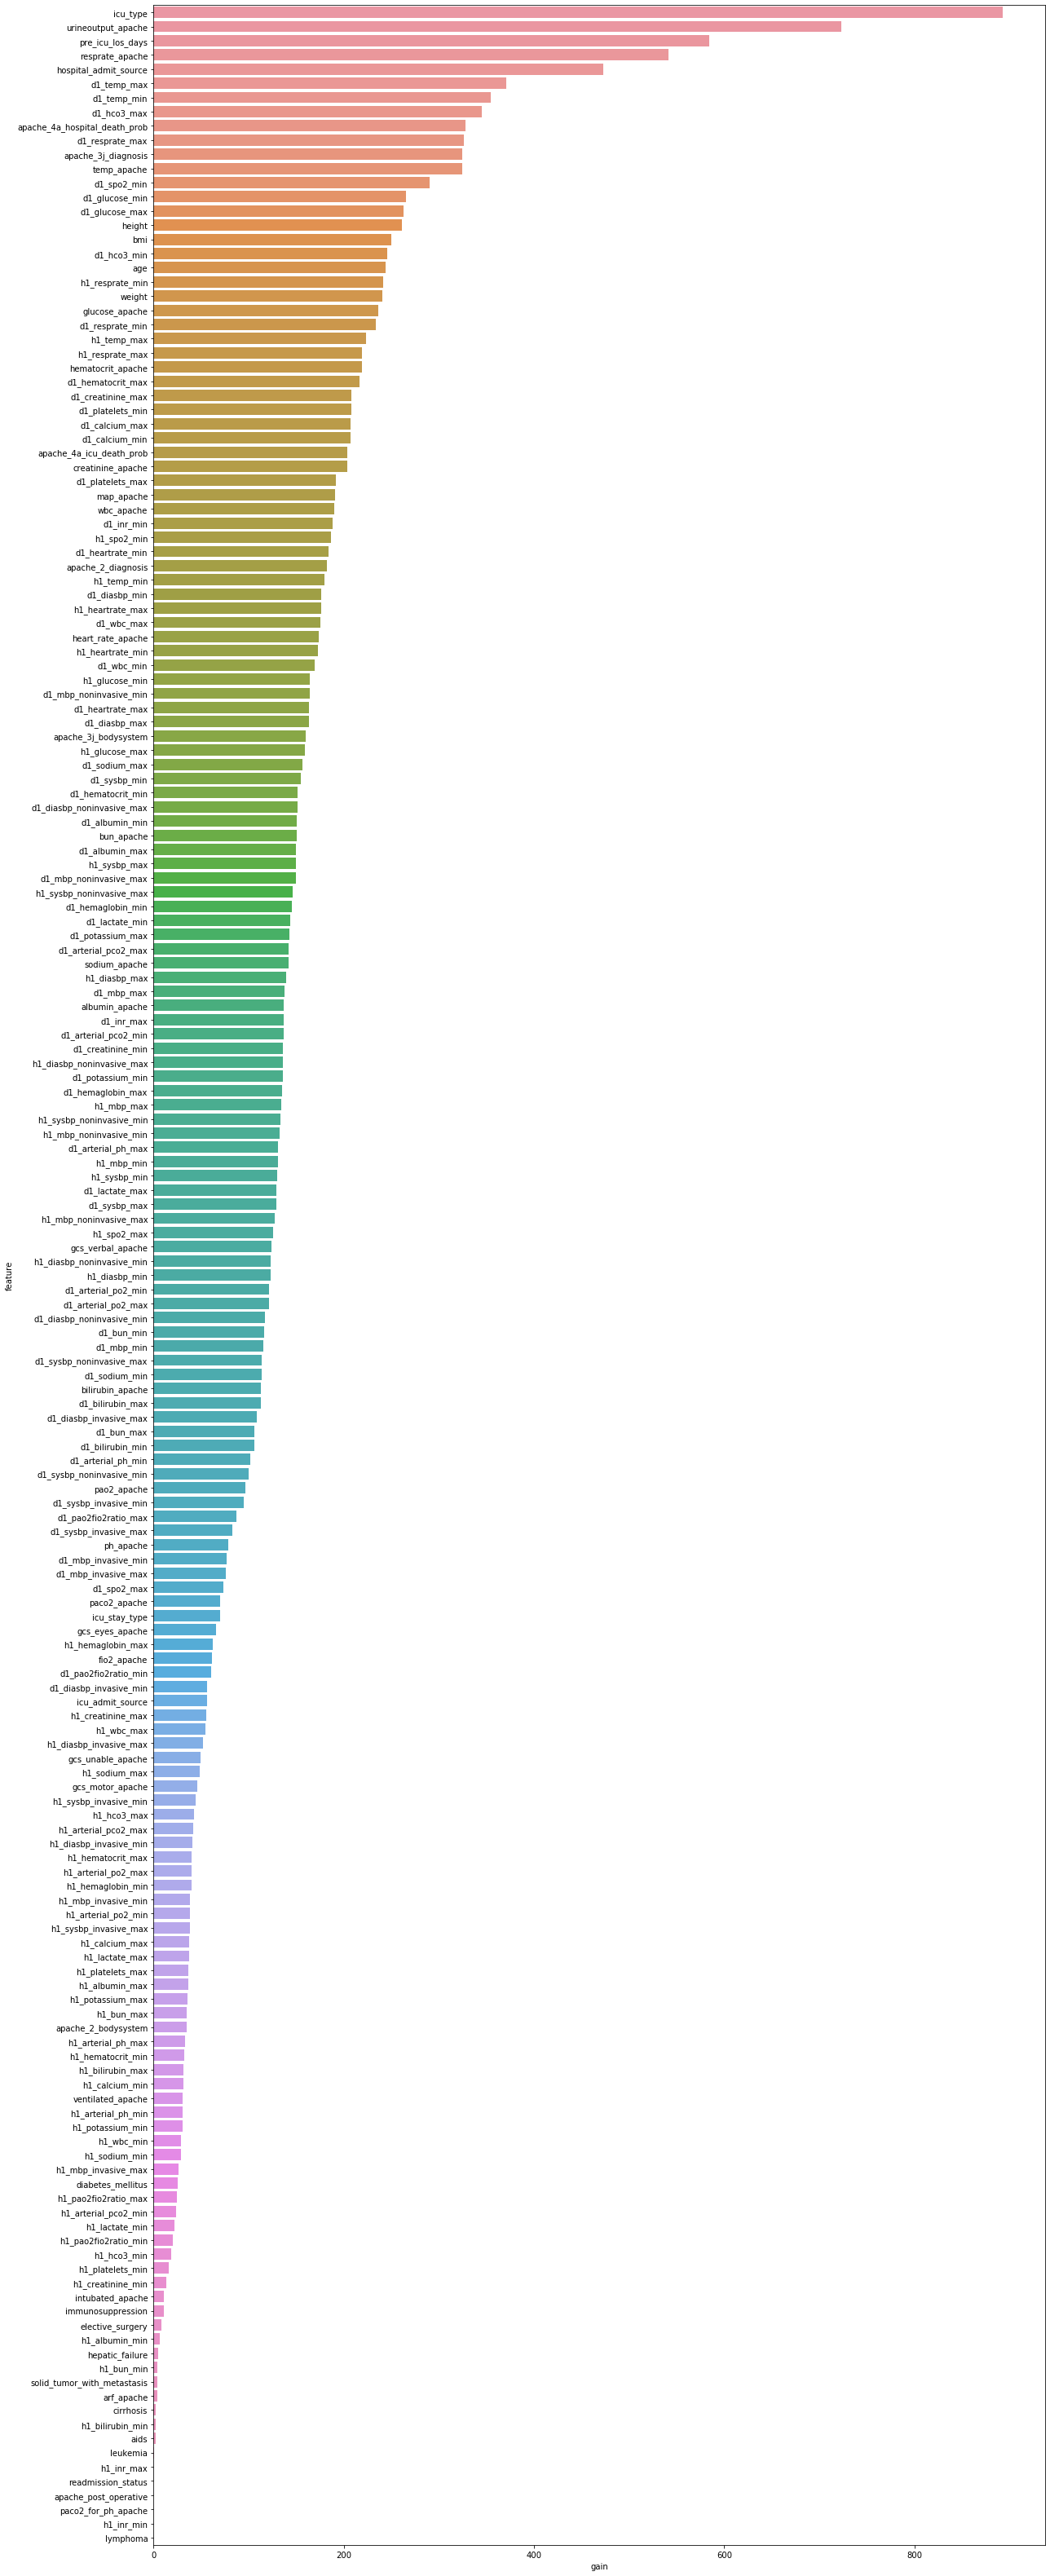

In [22]:
# I leave it to you to see what you can do with other features..
adversarial_features3 = adversarial_features3[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features3= adversarial_features3.sort_values('gain', ascending=False)

plot_importances(adversarial_features3, 'importances-lgb-v6')

icu_type 0 gain : 892.4


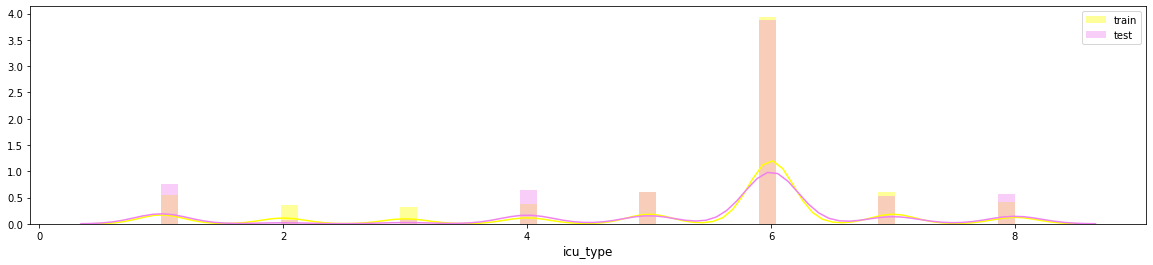

urineoutput_apache 1 gain : 722.8


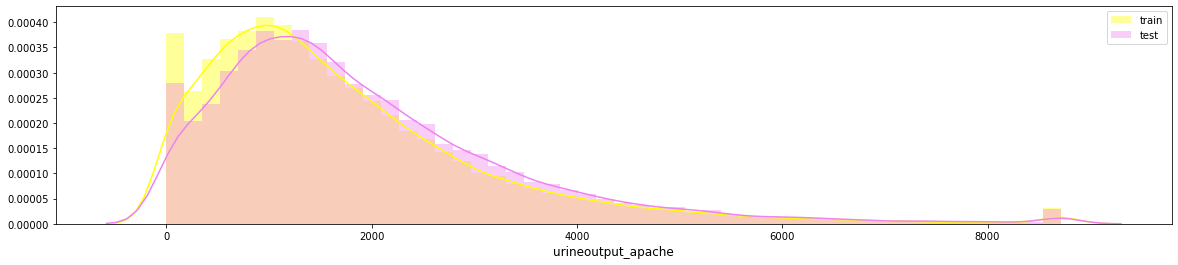

pre_icu_los_days 2 gain : 584.6


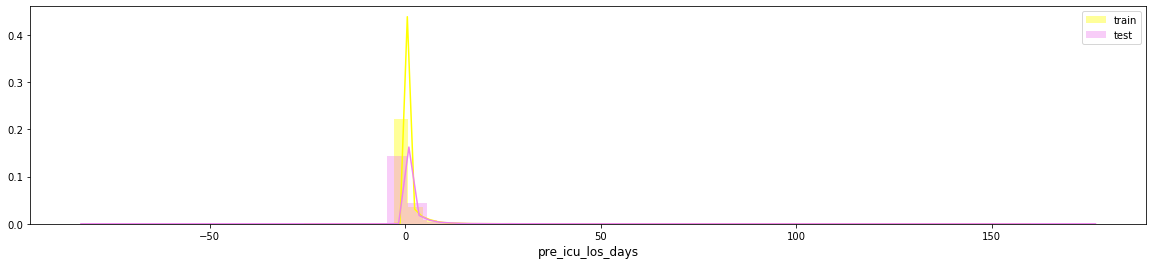

resprate_apache 3 gain : 541.6


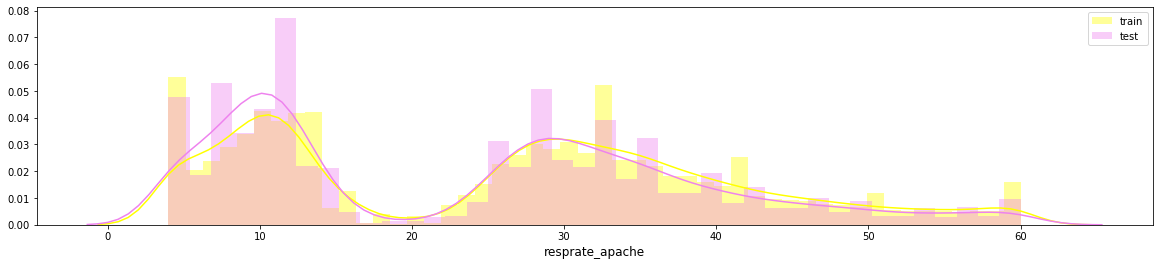

hospital_admit_source 4 gain : 473.2


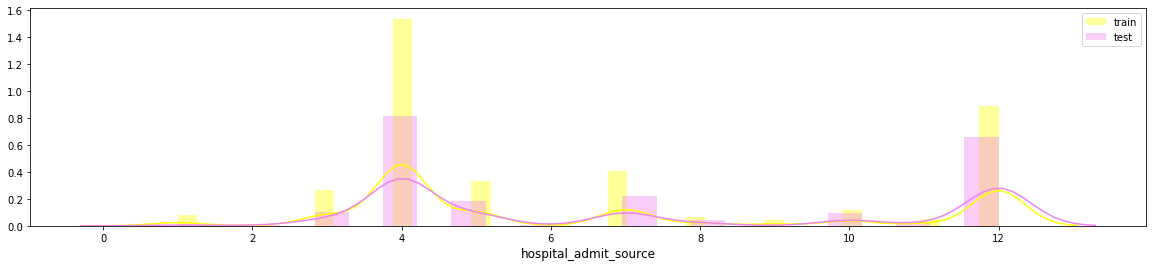

d1_temp_max 5 gain : 371.0


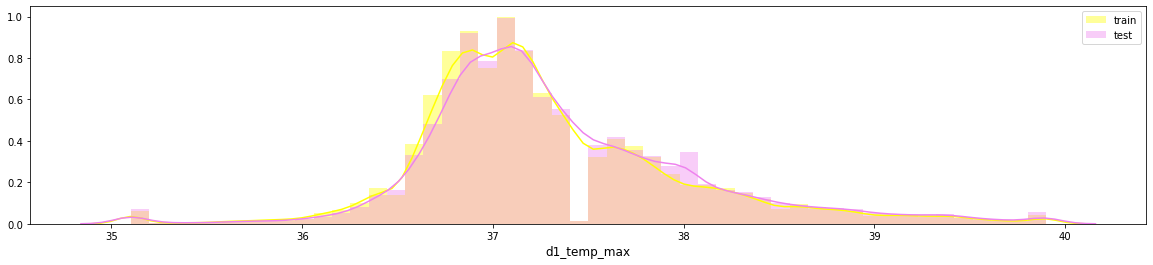

d1_temp_min 6 gain : 354.4


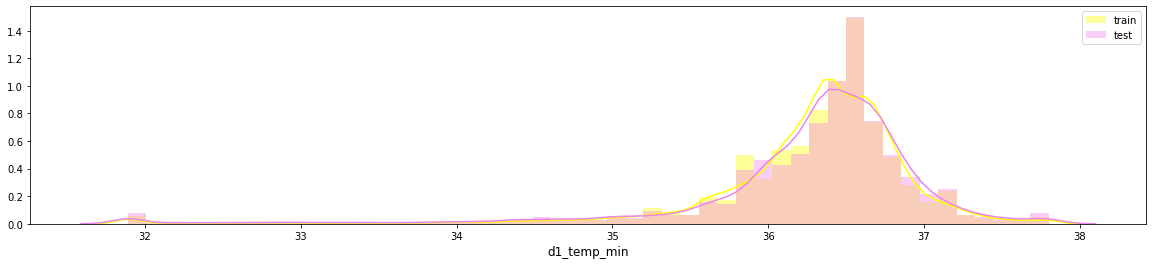

d1_hco3_max 7 gain : 345.4


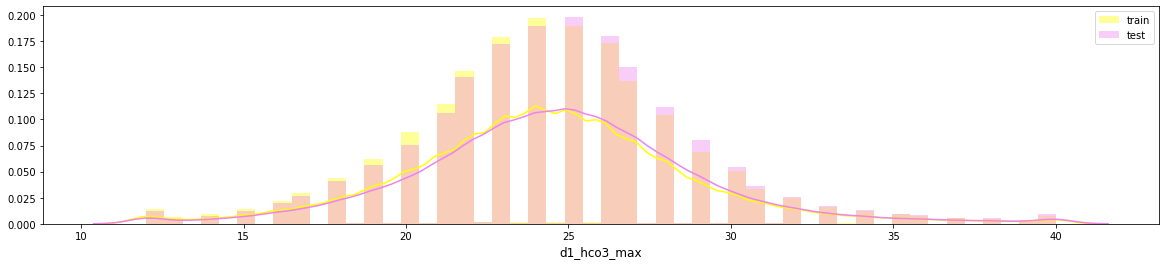

apache_4a_hospital_death_prob 8 gain : 328.2


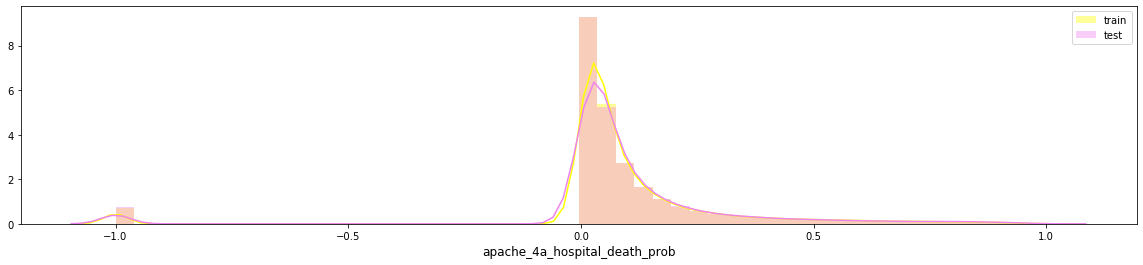

d1_resprate_max 9 gain : 326.0


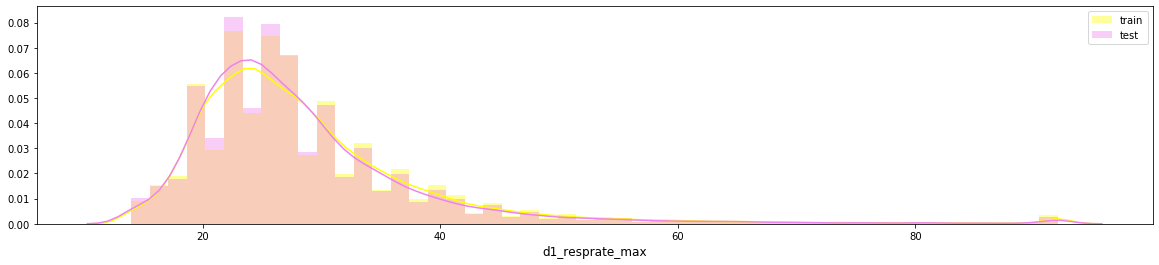

In [23]:
plot_differente_between_train_test(adversarial_features3)

In [24]:
# Lets remove hospital_id and icu_id

print('Difference between train and teste> -- hospital_id: ')
print(len(list(set(train['hospital_id']) - set(test['hospital_id']))))

print('\nDifference between train and teste> -- icu_id: ')
print(len(list(set(train['icu_id']) - set(test['icu_id']))))


# Drop features with zero importance
print('\nLength train features: {}'.format(len(features)))
for feat_to_remove in ['icu_id', 'hospital_id']:
    if feat_to_remove in categoricals_features:
        print('Removing from categoricals_features....{}'.format(feat_to_remove))
        categoricals_features.remove(feat_to_remove)
    if feat_to_remove in features:
        print('Removing from features....{}'.format(feat_to_remove))
        features.remove(feat_to_remove)
    
print('\nNew length train features: {}'.format(len(features)))

Difference between train and teste> -- hospital_id: 
138

Difference between train and teste> -- icu_id: 
229

Length train features: 181
Removing from features....icu_id
Removing from categoricals_features....hospital_id
Removing from features....hospital_id

New length train features: 179


# Model

In [25]:
# percentage of death , hopefully it s a bit unbalanced
train['hospital_death'].sum()/train['hospital_death'].count()

0.08630183289173836

# Hyper parameter tuning

In [26]:
# You want Bayesian Optimization?

# boll_BayesianOptimization = False
boll_BayesianOptimization = True

In [ ]:
%time

def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight,
                    subsample,
                    num_leaves,
                    min_split_gain):
#                     min_child_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    params['subsample']=subsample
    params['num_leaves']=num_leaves
    params['min_split_gain']=min_split_gain
   # params['min_child_weight']=min_child_weight
    
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'max_depth': (5, 17),
    'subsample': (0.5, 1),
    'num_leaves': (10, 45),
    'feature_fraction': (0.1, 1),
    'min_split_gain': (0.0, 0.1),
#     'min_child_weight': (1e-3, 50),
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'scale_pos_weight': (1, 10)
}

# ACTIVATE it if you want to search for better parameter
if boll_BayesianOptimization: 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

Wall time: 0 ns
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_sp... | num_le... | scale_... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.911413	valid_1's auc: 0.893402
[200]	training's auc: 0.921869	valid_1's auc: 0.898888
[300]	training's auc: 0.930618	valid_1's auc: 0.90208
[400]	training's auc: 0.938113	valid_1's auc: 0.904063
[500]	training's auc: 0.944862	valid_1's auc: 0.905216
[600]	training's auc: 0.950526	valid_1's auc: 0.905648
[700]	training's auc: 0.955618	valid_1's auc: 0.905978
[800]	training's auc: 0.960044	valid_1's auc: 0.906362
[900]	training's auc: 0.964059	valid_1's auc: 0.906286
Early stopping, best iteration is:
[834]	training's auc: 0.961535	valid_1's auc: 0.906418
Partial score of fold 0 is: 0.9064184722220129

[1000]	training's auc: 0.951589	valid_1's auc: 0.904806
[1100]	training's auc: 0.954374	valid_1's auc: 0.90497
[1200]	training's auc: 0.956895	valid_1's auc: 0.905085
[1300]	training's auc: 0.959785	valid_1's auc: 0.905129
[1400]	training's auc: 0.962449	valid_1's auc: 0.905289
[1500]	training's auc: 0.965139	valid_1's auc: 0.905421
Early stopping, best iteration is:
[1492]	training's auc: 0.964864	valid_1's auc: 0.905436
Partial score of fold 3 is: 0.9054363526002774
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.902198	valid_1's auc: 0.886878
[200]	training's auc: 0.912251	valid_1's auc: 0.894445
[300]	training's auc: 0.919881	valid_1's auc: 0.89876
[400]	training's auc: 0.926071	valid_1's auc: 0.90112
[500]	training's auc: 0.93163	valid_1's auc: 0.902743
[600]	training's auc: 0.936176	valid_1's auc: 0.903837
[700]	training's auc: 0.940393	valid_1's auc: 0.904788
[800]	training's auc: 0.944148	valid_1's auc: 0.905417
[900]	training's auc: 0.9474

[1500]	training's auc: 0.962368	valid_1's auc: 0.907426
[1600]	training's auc: 0.964536	valid_1's auc: 0.907543
[1700]	training's auc: 0.966589	valid_1's auc: 0.907602
[1800]	training's auc: 0.968587	valid_1's auc: 0.907686
Early stopping, best iteration is:
[1786]	training's auc: 0.968303	valid_1's auc: 0.907715
Partial score of fold 0 is: 0.9077146124469867
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.904861	valid_1's auc: 0.89053
[200]	training's auc: 0.912741	valid_1's auc: 0.895196
[300]	training's auc: 0.919026	valid_1's auc: 0.898273
[400]	training's auc: 0.924495	valid_1's auc: 0.900641
[500]	training's auc: 0.929444	valid_1's auc: 0.902467
[600]	training's auc: 0.934005	valid_1's auc: 0.903884
[700]	training's auc: 0.938235	valid_1's auc: 0.905015
[800]	training's auc: 0.942107	valid_1's auc: 0.905838
[900]	training's auc: 0.945708	valid_1's auc: 0.906593
[1000]	training's auc: 0.949051	valid_1's auc: 0.907086
[1100]	training's auc: 0.9

[800]	training's auc: 0.956532	valid_1's auc: 0.904416
[900]	training's auc: 0.960576	valid_1's auc: 0.904558
[1000]	training's auc: 0.964384	valid_1's auc: 0.904854
[1100]	training's auc: 0.96778	valid_1's auc: 0.904948
[1200]	training's auc: 0.970771	valid_1's auc: 0.904888
Early stopping, best iteration is:
[1102]	training's auc: 0.967854	valid_1's auc: 0.904966
Partial score of fold 3 is: 0.9049655558867173
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.908079	valid_1's auc: 0.892274
[200]	training's auc: 0.919222	valid_1's auc: 0.89938
[300]	training's auc: 0.927768	valid_1's auc: 0.903169
[400]	training's auc: 0.93499	valid_1's auc: 0.905202
[500]	training's auc: 0.94125	valid_1's auc: 0.906642
[600]	training's auc: 0.946754	valid_1's auc: 0.90761
[700]	training's auc: 0.951701	valid_1's auc: 0.908077
[800]	training's auc: 0.956239	valid_1's auc: 0.908258
[900]	training's auc: 0.96033	valid_1's auc: 0.908326
[1000]	training's auc: 0.963952	v

[200]	training's auc: 0.91603	valid_1's auc: 0.897833
[300]	training's auc: 0.924702	valid_1's auc: 0.901531
[400]	training's auc: 0.932024	valid_1's auc: 0.903594
[500]	training's auc: 0.938249	valid_1's auc: 0.9048
[600]	training's auc: 0.944199	valid_1's auc: 0.905919
[700]	training's auc: 0.949363	valid_1's auc: 0.906535
[800]	training's auc: 0.953878	valid_1's auc: 0.906807
[900]	training's auc: 0.957626	valid_1's auc: 0.907178
[1000]	training's auc: 0.961248	valid_1's auc: 0.907328
[1100]	training's auc: 0.964588	valid_1's auc: 0.907543
[1200]	training's auc: 0.967684	valid_1's auc: 0.907617
[1300]	training's auc: 0.970589	valid_1's auc: 0.90786
Early stopping, best iteration is:
[1295]	training's auc: 0.970462	valid_1's auc: 0.907903
Partial score of fold 4 is: 0.9079026262729368
Our oof AUC score is:  0.9057953339858567
auc:  0.9057953339858567
|  7        |  0.9058   |  0.8855   |  0.2751   |  4.832    |  0.01933  |  5.834    |  0.04805  |  27.85    |  4.317    |  0.7172   |  

Partial score of fold 0 is: 0.9077794420732213
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.889289	valid_1's auc: 0.881557
[200]	training's auc: 0.899981	valid_1's auc: 0.890483
[300]	training's auc: 0.906624	valid_1's auc: 0.895323
[400]	training's auc: 0.911493	valid_1's auc: 0.898505
[500]	training's auc: 0.915683	valid_1's auc: 0.900394
[600]	training's auc: 0.919229	valid_1's auc: 0.90174
[700]	training's auc: 0.922603	valid_1's auc: 0.903017
[800]	training's auc: 0.92565	valid_1's auc: 0.903984
[900]	training's auc: 0.928729	valid_1's auc: 0.904637
[1000]	training's auc: 0.931259	valid_1's auc: 0.905264
[1100]	training's auc: 0.933719	valid_1's auc: 0.905691
[1200]	training's auc: 0.936179	valid_1's auc: 0.906048
[1300]	training's auc: 0.938292	valid_1's auc: 0.906267
[1400]	training's auc: 0.940389	valid_1's auc: 0.906461
[1500]	training's auc: 0.942357	valid_1's auc: 0.906486
[1600]	training's auc: 0.944336	valid_1's auc: 0.90661
[1700]	

[1000]	training's auc: 0.929292	valid_1's auc: 0.901024
[1100]	training's auc: 0.9316	valid_1's auc: 0.901454
[1200]	training's auc: 0.933634	valid_1's auc: 0.901773
[1300]	training's auc: 0.935716	valid_1's auc: 0.90196
[1400]	training's auc: 0.937778	valid_1's auc: 0.902208
[1500]	training's auc: 0.939635	valid_1's auc: 0.902322
[1600]	training's auc: 0.941467	valid_1's auc: 0.902535
[1700]	training's auc: 0.943244	valid_1's auc: 0.902602
[1800]	training's auc: 0.944938	valid_1's auc: 0.902819
[1900]	training's auc: 0.946571	valid_1's auc: 0.902912
[2000]	training's auc: 0.948145	valid_1's auc: 0.90287
Early stopping, best iteration is:
[1950]	training's auc: 0.947416	valid_1's auc: 0.90294
Partial score of fold 2 is: 0.9029400612413819
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.891734	valid_1's auc: 0.886359
[200]	training's auc: 0.900338	valid_1's auc: 0.892571
[300]	training's auc: 0.906574	valid_1's auc: 0.896303
[400]	training's auc: 0.

[600]	training's auc: 0.942571	valid_1's auc: 0.905075
[700]	training's auc: 0.947412	valid_1's auc: 0.905713
[800]	training's auc: 0.951632	valid_1's auc: 0.906177
[900]	training's auc: 0.955568	valid_1's auc: 0.906454
[1000]	training's auc: 0.959213	valid_1's auc: 0.906682
[1100]	training's auc: 0.962491	valid_1's auc: 0.906744
[1200]	training's auc: 0.965486	valid_1's auc: 0.906997
[1300]	training's auc: 0.968297	valid_1's auc: 0.90724
[1400]	training's auc: 0.970821	valid_1's auc: 0.907238
Early stopping, best iteration is:
[1349]	training's auc: 0.969549	valid_1's auc: 0.90734
Partial score of fold 0 is: 0.9073398444390505
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.906597	valid_1's auc: 0.889717
[200]	training's auc: 0.917078	valid_1's auc: 0.895882
[300]	training's auc: 0.925127	valid_1's auc: 0.899991
[400]	training's auc: 0.931809	valid_1's auc: 0.902434
[500]	training's auc: 0.937725	valid_1's auc: 0.904104
[600]	training's auc: 0.942

[800]	training's auc: 0.96831	valid_1's auc: 0.90543
[900]	training's auc: 0.97232	valid_1's auc: 0.9056
[1000]	training's auc: 0.975883	valid_1's auc: 0.905682
[1100]	training's auc: 0.978898	valid_1's auc: 0.905835
[1200]	training's auc: 0.981623	valid_1's auc: 0.905668
Early stopping, best iteration is:
[1121]	training's auc: 0.979491	valid_1's auc: 0.905907
Partial score of fold 3 is: 0.9059073377832983
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.914624	valid_1's auc: 0.890891
[200]	training's auc: 0.927298	valid_1's auc: 0.898294
[300]	training's auc: 0.936797	valid_1's auc: 0.902334
[400]	training's auc: 0.944817	valid_1's auc: 0.904988
[500]	training's auc: 0.951874	valid_1's auc: 0.90658
[600]	training's auc: 0.957936	valid_1's auc: 0.907333
[700]	training's auc: 0.963267	valid_1's auc: 0.907938
[800]	training's auc: 0.967986	valid_1's auc: 0.908439
[900]	training's auc: 0.972093	valid_1's auc: 0.908776
[1000]	training's auc: 0.975577	v

[100]	training's auc: 0.887606	valid_1's auc: 0.878067
[200]	training's auc: 0.894536	valid_1's auc: 0.884397
[300]	training's auc: 0.900478	valid_1's auc: 0.889893
[400]	training's auc: 0.905035	valid_1's auc: 0.894027
[500]	training's auc: 0.908668	valid_1's auc: 0.89672
[600]	training's auc: 0.911675	valid_1's auc: 0.898787
[700]	training's auc: 0.914574	valid_1's auc: 0.900338
[800]	training's auc: 0.91701	valid_1's auc: 0.901533
[900]	training's auc: 0.919402	valid_1's auc: 0.902435
[1000]	training's auc: 0.921644	valid_1's auc: 0.903196
[1100]	training's auc: 0.923746	valid_1's auc: 0.903832
[1200]	training's auc: 0.925913	valid_1's auc: 0.904394
[1300]	training's auc: 0.927932	valid_1's auc: 0.904954
[1400]	training's auc: 0.929963	valid_1's auc: 0.905465
[1500]	training's auc: 0.931769	valid_1's auc: 0.905915
[1600]	training's auc: 0.933449	valid_1's auc: 0.90627
[1700]	training's auc: 0.935076	valid_1's auc: 0.906548
[1800]	training's auc: 0.936687	valid_1's auc: 0.906813
[190

[1400]	training's auc: 0.941931	valid_1's auc: 0.906252
[1500]	training's auc: 0.94392	valid_1's auc: 0.906377
[1600]	training's auc: 0.94583	valid_1's auc: 0.906491
Early stopping, best iteration is:
[1544]	training's auc: 0.944832	valid_1's auc: 0.906568
Partial score of fold 0 is: 0.9065676180539954
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.891562	valid_1's auc: 0.882158
[200]	training's auc: 0.901034	valid_1's auc: 0.889111
[300]	training's auc: 0.90757	valid_1's auc: 0.893744
[400]	training's auc: 0.912618	valid_1's auc: 0.896919
[500]	training's auc: 0.916829	valid_1's auc: 0.899431
[600]	training's auc: 0.920537	valid_1's auc: 0.901111
[700]	training's auc: 0.923868	valid_1's auc: 0.902139
[800]	training's auc: 0.927185	valid_1's auc: 0.903026
[900]	training's auc: 0.930116	valid_1's auc: 0.903748
[1000]	training's auc: 0.932897	valid_1's auc: 0.904548
[1100]	training's auc: 0.935538	valid_1's auc: 0.904668
[1200]	training's auc: 0.937

[4300]	training's auc: 0.945759	valid_1's auc: 0.905646
[4400]	training's auc: 0.946476	valid_1's auc: 0.905715
[4500]	training's auc: 0.947148	valid_1's auc: 0.905761
[4600]	training's auc: 0.947814	valid_1's auc: 0.90577
[4700]	training's auc: 0.948497	valid_1's auc: 0.905805
[4800]	training's auc: 0.949168	valid_1's auc: 0.905823
[4900]	training's auc: 0.949817	valid_1's auc: 0.905845
[5000]	training's auc: 0.950426	valid_1's auc: 0.905869
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.950426	valid_1's auc: 0.905869
Partial score of fold 0 is: 0.9058693049811768
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.88135	valid_1's auc: 0.875333
[200]	training's auc: 0.887697	valid_1's auc: 0.88097
[300]	training's auc: 0.893041	valid_1's auc: 0.885595
[400]	training's auc: 0.897555	valid_1's auc: 0.889246
[500]	training's auc: 0.901038	valid_1's auc: 0.891939
[600]	training's auc: 0.90393	valid_1's auc: 0.894106
[700]	trainin

Partial score of fold 3 is: 0.9041675761888738
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.881638	valid_1's auc: 0.87365
[200]	training's auc: 0.887606	valid_1's auc: 0.87965
[300]	training's auc: 0.892591	valid_1's auc: 0.884674
[400]	training's auc: 0.896916	valid_1's auc: 0.889108
[500]	training's auc: 0.900451	valid_1's auc: 0.892623
[600]	training's auc: 0.903361	valid_1's auc: 0.895155
[700]	training's auc: 0.905851	valid_1's auc: 0.89697
[800]	training's auc: 0.908065	valid_1's auc: 0.898434
[900]	training's auc: 0.910061	valid_1's auc: 0.899665
[1000]	training's auc: 0.911875	valid_1's auc: 0.900695
[1100]	training's auc: 0.913561	valid_1's auc: 0.901452
[1200]	training's auc: 0.915169	valid_1's auc: 0.902109
[1300]	training's auc: 0.916652	valid_1's auc: 0.902701
[1400]	training's auc: 0.918088	valid_1's auc: 0.903191
[1500]	training's auc: 0.919467	valid_1's auc: 0.903628
[1600]	training's auc: 0.920783	valid_1's auc: 0.903991
[1700]	

[1100]	training's auc: 0.942819	valid_1's auc: 0.903211
[1200]	training's auc: 0.945753	valid_1's auc: 0.903524
[1300]	training's auc: 0.948642	valid_1's auc: 0.903862
[1400]	training's auc: 0.951187	valid_1's auc: 0.904092
[1500]	training's auc: 0.953721	valid_1's auc: 0.904297
[1600]	training's auc: 0.956017	valid_1's auc: 0.904534
[1700]	training's auc: 0.958129	valid_1's auc: 0.904691
[1800]	training's auc: 0.960143	valid_1's auc: 0.904833
[1900]	training's auc: 0.962156	valid_1's auc: 0.90491
[2000]	training's auc: 0.964026	valid_1's auc: 0.90491
Early stopping, best iteration is:
[1943]	training's auc: 0.962961	valid_1's auc: 0.904958
Partial score of fold 3 is: 0.9049579794143854
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899609	valid_1's auc: 0.88383
[200]	training's auc: 0.906176	valid_1's auc: 0.889344
[300]	training's auc: 0.911605	valid_1's auc: 0.89374
[400]	training's auc: 0.916455	valid_1's auc: 0.897117
[500]	training's auc: 0.

[2000]	training's auc: 0.933219	valid_1's auc: 0.900429
[2100]	training's auc: 0.934432	valid_1's auc: 0.900531
[2200]	training's auc: 0.935664	valid_1's auc: 0.900664
[2300]	training's auc: 0.936815	valid_1's auc: 0.900711
[2400]	training's auc: 0.937946	valid_1's auc: 0.90088
[2500]	training's auc: 0.939087	valid_1's auc: 0.901029
[2600]	training's auc: 0.940116	valid_1's auc: 0.901158
[2700]	training's auc: 0.941147	valid_1's auc: 0.901278
[2800]	training's auc: 0.942147	valid_1's auc: 0.901396
[2900]	training's auc: 0.943117	valid_1's auc: 0.9015
[3000]	training's auc: 0.944026	valid_1's auc: 0.901601
[3100]	training's auc: 0.944986	valid_1's auc: 0.901648
[3200]	training's auc: 0.946014	valid_1's auc: 0.901754
[3300]	training's auc: 0.946871	valid_1's auc: 0.901835
[3400]	training's auc: 0.947806	valid_1's auc: 0.901888
Early stopping, best iteration is:
[3395]	training's auc: 0.947778	valid_1's auc: 0.901892
Partial score of fold 2 is: 0.9018917435701826
Training until validation

[400]	training's auc: 0.923449	valid_1's auc: 0.896272
[500]	training's auc: 0.928366	valid_1's auc: 0.898076
[600]	training's auc: 0.932936	valid_1's auc: 0.899175
[700]	training's auc: 0.936677	valid_1's auc: 0.900089
[800]	training's auc: 0.940179	valid_1's auc: 0.900906
[900]	training's auc: 0.943517	valid_1's auc: 0.901541
[1000]	training's auc: 0.946532	valid_1's auc: 0.90194
[1100]	training's auc: 0.949209	valid_1's auc: 0.902364
[1200]	training's auc: 0.951915	valid_1's auc: 0.902598
[1300]	training's auc: 0.954142	valid_1's auc: 0.90284
[1400]	training's auc: 0.956386	valid_1's auc: 0.903093
[1500]	training's auc: 0.958699	valid_1's auc: 0.903393
[1600]	training's auc: 0.960898	valid_1's auc: 0.903443
[1700]	training's auc: 0.963098	valid_1's auc: 0.903657
[1800]	training's auc: 0.965001	valid_1's auc: 0.90367
Early stopping, best iteration is:
[1733]	training's auc: 0.963663	valid_1's auc: 0.903702
Partial score of fold 2 is: 0.9037019224245677
Training until validation score

[1500]	training's auc: 0.952789	valid_1's auc: 0.903557
[1600]	training's auc: 0.955089	valid_1's auc: 0.903788
[1700]	training's auc: 0.957264	valid_1's auc: 0.903758
Early stopping, best iteration is:
[1656]	training's auc: 0.956302	valid_1's auc: 0.903877
Partial score of fold 3 is: 0.9038774086067293
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.898436	valid_1's auc: 0.883907
[200]	training's auc: 0.905065	valid_1's auc: 0.889178
[300]	training's auc: 0.910678	valid_1's auc: 0.893928
[400]	training's auc: 0.915787	valid_1's auc: 0.897173
[500]	training's auc: 0.920307	valid_1's auc: 0.899509
[600]	training's auc: 0.92428	valid_1's auc: 0.901048
[700]	training's auc: 0.928444	valid_1's auc: 0.902337
[800]	training's auc: 0.932248	valid_1's auc: 0.903075
[900]	training's auc: 0.936215	valid_1's auc: 0.903756
[1000]	training's auc: 0.939422	valid_1's auc: 0.904339
[1100]	training's auc: 0.942346	valid_1's auc: 0.904474
[1200]	training's auc: 0.9

[800]	training's auc: 0.969438	valid_1's auc: 0.906754
[900]	training's auc: 0.973911	valid_1's auc: 0.907025
[1000]	training's auc: 0.977895	valid_1's auc: 0.906892
Early stopping, best iteration is:
[911]	training's auc: 0.974412	valid_1's auc: 0.907083
Partial score of fold 1 is: 0.9070825612828427
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.910926	valid_1's auc: 0.887663
[200]	training's auc: 0.924807	valid_1's auc: 0.89427
[300]	training's auc: 0.935665	valid_1's auc: 0.897896
[400]	training's auc: 0.944553	valid_1's auc: 0.899793
[500]	training's auc: 0.952345	valid_1's auc: 0.900906
[600]	training's auc: 0.959192	valid_1's auc: 0.901505
[700]	training's auc: 0.965111	valid_1's auc: 0.901958
[800]	training's auc: 0.97022	valid_1's auc: 0.9022
[900]	training's auc: 0.974423	valid_1's auc: 0.902243
[1000]	training's auc: 0.978321	valid_1's auc: 0.902351
[1100]	training's auc: 0.981668	valid_1's auc: 0.902796
[1200]	training's auc: 0.984418	

[1700]	training's auc: 0.963774	valid_1's auc: 0.906544
[1800]	training's auc: 0.965922	valid_1's auc: 0.906597
[1900]	training's auc: 0.968025	valid_1's auc: 0.906691
[2000]	training's auc: 0.969969	valid_1's auc: 0.906761
[2100]	training's auc: 0.971805	valid_1's auc: 0.906807
[2200]	training's auc: 0.973535	valid_1's auc: 0.906894
[2300]	training's auc: 0.975246	valid_1's auc: 0.90696
[2400]	training's auc: 0.976748	valid_1's auc: 0.907026
[2500]	training's auc: 0.978238	valid_1's auc: 0.907116
[2600]	training's auc: 0.979685	valid_1's auc: 0.907218
[2700]	training's auc: 0.98098	valid_1's auc: 0.907313
[2800]	training's auc: 0.982242	valid_1's auc: 0.907356
Early stopping, best iteration is:
[2750]	training's auc: 0.981602	valid_1's auc: 0.907418
Partial score of fold 3 is: 0.9074175058803415
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903723	valid_1's auc: 0.890219


In [ ]:
if LGB_BO:
    LGB_BO.max['params']

In [ ]:
# params = {'feature_fraction': 0.9,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'learning_rate': 0.1,
#  'max_depth': 13,
#  'subsample_freq': 1,
#  'scale_pos_weight':1}

# Best Hyperparams from Bayesian Optimization in notebook lgb-v2
# params = {'feature_fraction': 0.524207414205945,
#  'lambda_l1': 4.171808735757517,
#  'lambda_l2': 4.6435328298317256,
#  'learning_rate': 0.007897539397989824,
#  'max_depth': 16.62053004755999,
#  'scale_pos_weight': 1.2199266532301127,
#  'subsample_freq': 1.0276518730971627}


# # Best Hyperparams from Bayesian Optimization in notebook lgb-v3
# params = {'feature_fraction': 0.524207414205945,
#  'lambda_l1': 4.171808735757517,
#  'lambda_l2': 4.6435328298317256,
#  'learning_rate': 0.007897539397989824,
#  'max_depth': 16.62053004755999,
#  'scale_pos_weight': 1.2199266532301127,
#  'subsample_freq': 1.0276518730971627}

# # Best Hyperparams from Bayesian Optimization in notebook lgb-v4
# params = {'feature_fraction': 0.5348508368206359,
#  'lambda_l1': 0.0009370993396629057,
#  'lambda_l2': 4.743745312344983,
#  'learning_rate': 0.012891827059322746,
#  'max_depth': 15.784155449197529,
#  'scale_pos_weight': 1.0325760631926175,
#  'subsample_freq': 1.0744384574974872}


# Best Hyperparams from Bayesian Optimization in notebook lgb-v5
params = {'feature_fraction': 0.3245039721724266,
 'lambda_l1': 1.416727346446085,
 'lambda_l2': 2.779776916582821,
 'learning_rate': 0.006854369969433722,
 'max_depth': 16.673905691676964,
 'min_split_gain': 0.05643417986130283,
 'num_leaves': 44.8672896759208,
 'scale_pos_weight': 1.1577974342088542,
 'subsample': 0.630352165410007,
 'subsample_freq': 1.2158674819047501}

In [ ]:
%time

if boll_BayesianOptimization: # ACTIVATE it if you want to search/use for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps= LGB_BO.max['params'])
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

Feature Importance from the lightgbm model (gain)

In [ ]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

In [ ]:
plot_importances(imp_df, 'importances-lgb-v5-lgb_model')

# Feature Importance by permutation importance algo

In [ ]:
import shap
explainer   =  shap.TreeExplainer(lgb_model.model)
shap_values = explainer.shap_values(train[features].iloc[:1000,:])
shap.summary_plot(shap_values, train[features].iloc[:1000,:])

# Some univariate plot of the best feature

In [ ]:
print('AUC Version 1: ', lgb_model.score)
#print('AUC:Version 2: ', lgb_model_v2.score)

## Submissing File

In [ ]:
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission6-lgb-v6-2.csv",index=False)

test[["encounter_id","hospital_death"]].head()

In [ ]:
from datetime import datetime
datetime.now()